<a href="https://colab.research.google.com/github/naimish75/AI-Powered-Adverse-Event-Forecasting-Using-Temporal-Data/blob/main/Drug_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
!pip install squarify wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import squarify  # For treemap
from wordcloud import WordCloud

# Set style for visualizations
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
df = pd.read_csv("/content/gdrive/MyDrive/DRUG Analysis training/FAERS.csv")
df.head(-1)

<ipython-input-3-6def54196d06>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/gdrive/MyDrive/DRUG Analysis training/FAERS.csv")


,safetyreport_id,country,report_date,drug,indication,reaction
0,22723993,US,2023-07-19,REVLIMID,Plasma cell myeloma,Hypoaesthesia
1,22736298,US,2023-07-21,XGEVA,Metastases to bone,Rash
2,22736298,US,2023-07-21,IBRANCE,Breast cancer metastatic,Rash
3,22765280,DE,2023-07-31,CEFUROXIME AXETIL,Bacterial infection,Swollen tongue
4,22765280,DE,2023-07-31,CEFUROXIME AXETIL,Bacterial infection,Hypoaesthesia oral
...,...,...,...,...,...,...
174841101,24805319,US,2024-12-24,FENTANYL,NaN,Suicide attempt
174841102,24805319,US,2024-12-24,FENTANYL,NaN,Drug screen positive
174841103,24830572,US,2024-12-27,ENBREL,Rheumatoid arthritis,Therapy interrupted
174841104,24830572,US,2024-12-27,ENBREL,Rheumatoid arthritis,COVID-19


<Figure size 1200x600 with 0 Axes>

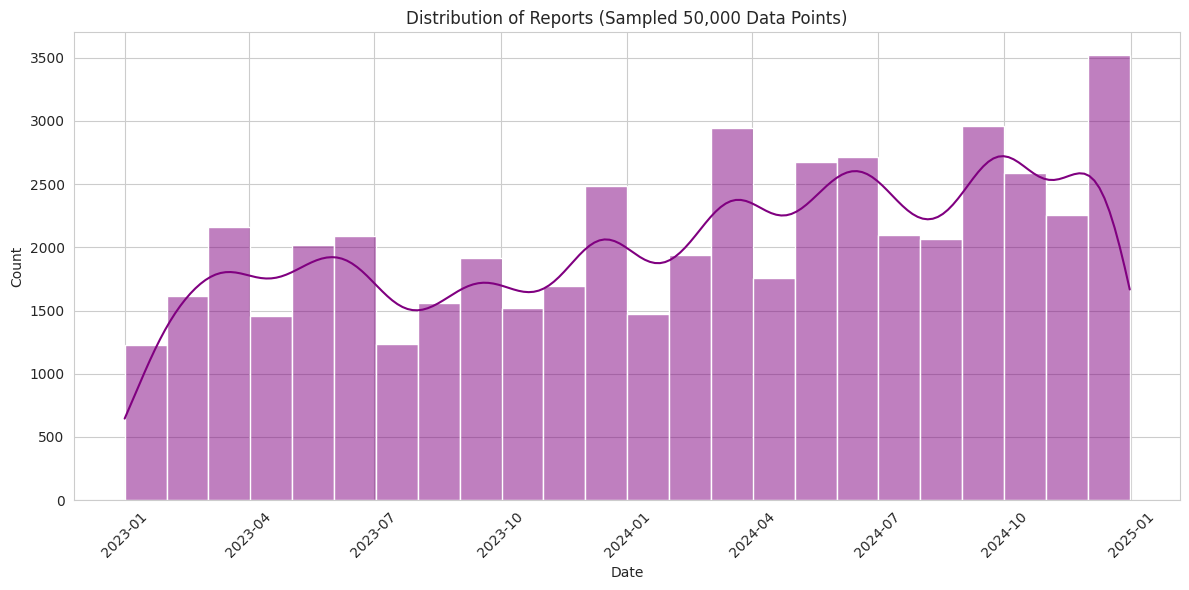

In [ ]:
df_sampled = df.sample(n=50000, random_state=42)


df_sampled['report_date'] = pd.to_datetime(df_sampled['report_date'])


plt.figure(figsize=(12, 6))
sns.histplot(df_sampled['report_date'], bins=24, kde=True, color='purple')
plt.title('Distribution of Reports (Sampled 50,000 Data Points)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


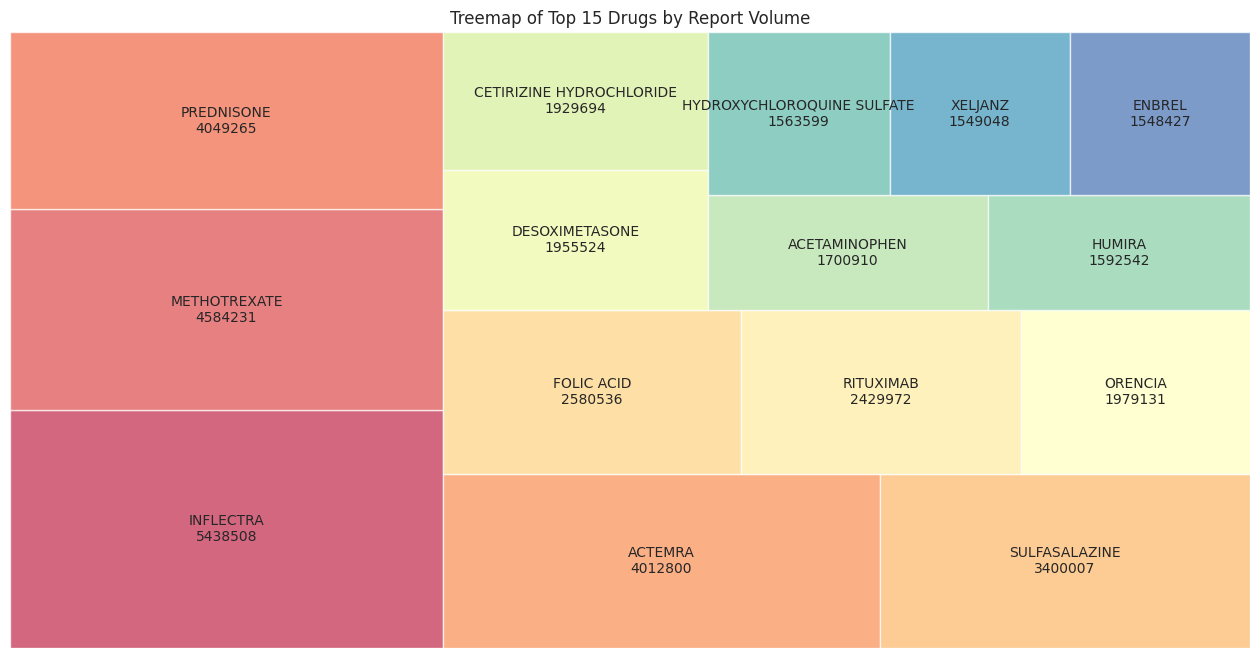

In [ ]:
plt.figure(figsize=(16, 8))
drug_counts = df['drug'].value_counts().nlargest(15)
squarify.plot(sizes=drug_counts.values,
             label=[f"{drug}\n{count}" for drug, count in zip(drug_counts.index, drug_counts.values)],
             color=sns.color_palette('Spectral', len(drug_counts)),
             alpha=0.7)
plt.title('Treemap of Top 15 Drugs by Report Volume')
plt.axis('off')
plt.show()

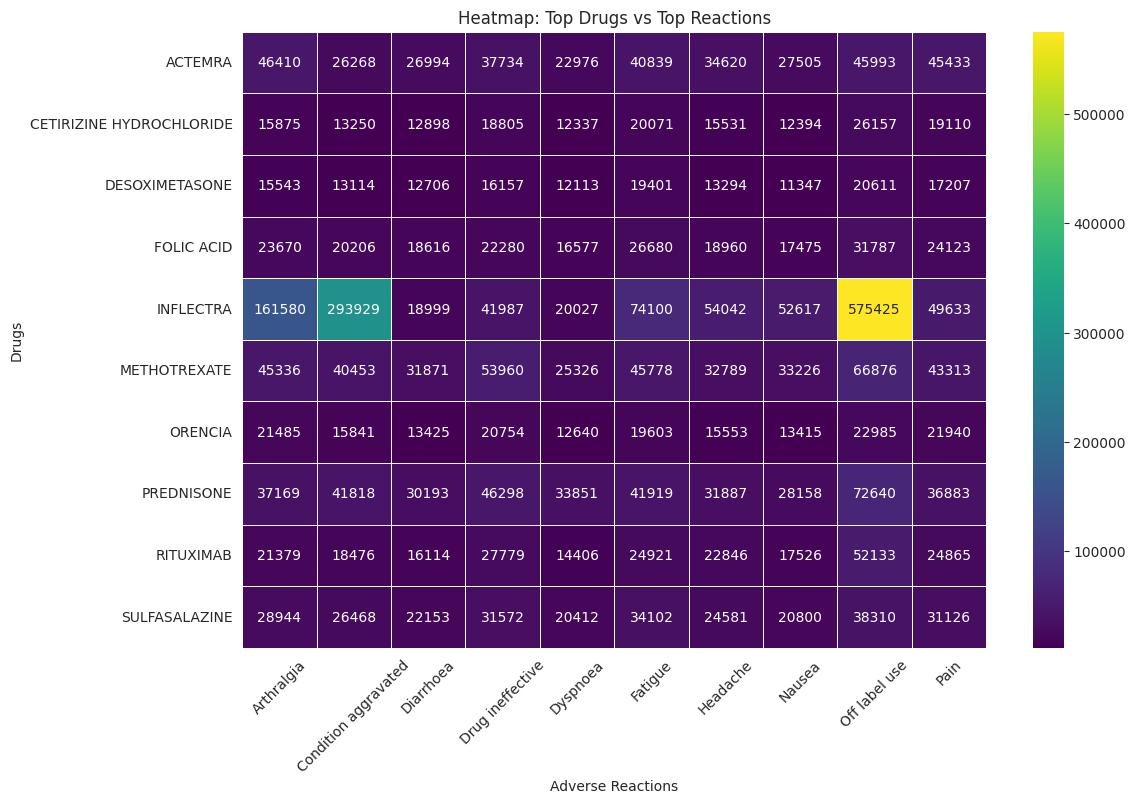

In [ ]:
top_drugs = df['drug'].value_counts().nlargest(10).index
top_reactions = df['reaction'].value_counts().nlargest(10).index
heatmap_data = pd.crosstab(df[df['drug'].isin(top_drugs)]['drug'],
                          df[df['reaction'].isin(top_reactions)]['reaction'])

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='d', linewidths=.5)
plt.title('Heatmap: Top Drugs vs Top Reactions')
plt.xlabel('Adverse Reactions')
plt.ylabel('Drugs')
plt.xticks(rotation=45)
plt.show()

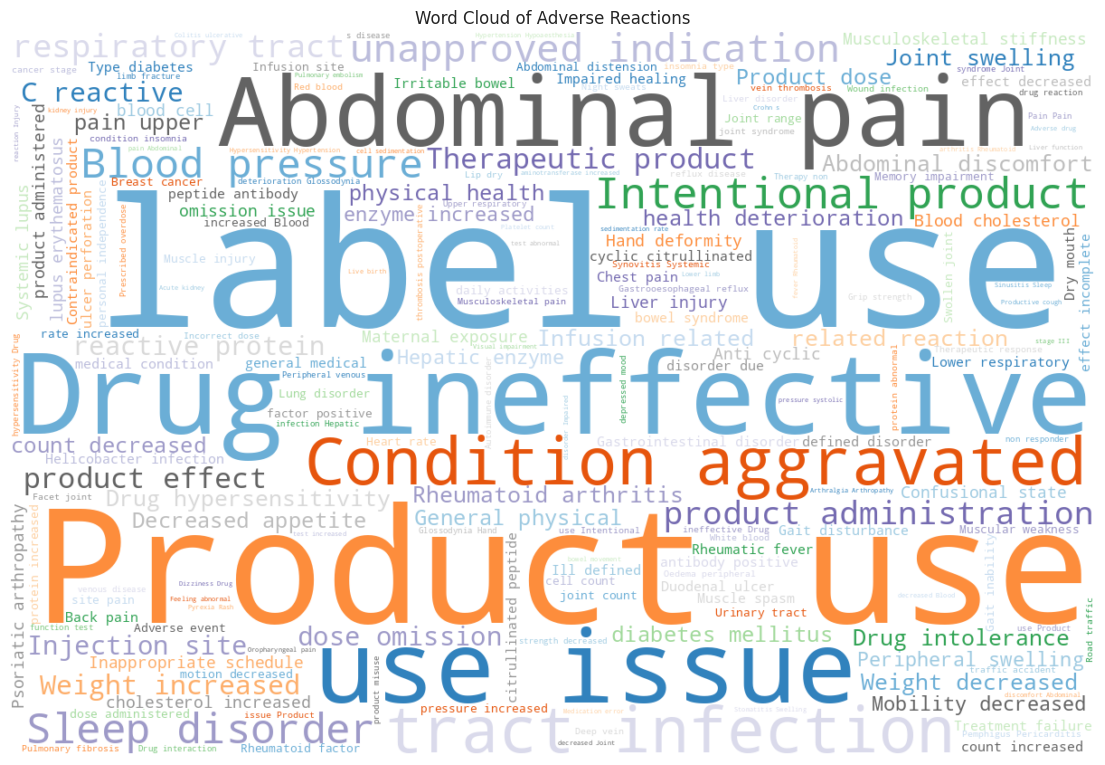

In [ ]:
reaction_text = ' '.join(df['reaction'].dropna())
wordcloud = WordCloud(width=1200, height=800,
                      background_color='white',
                      colormap='tab20c').generate(reaction_text)

plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Adverse Reactions')
plt.show()

In [15]:
import plotly.graph_objects as go

# Prepare data for Sankey diagram
def prepare_sankey_data(df, top_drugs=15, top_reactions=10):
    # Get top drugs and their top reactions
    top_drug_list = df['drug'].value_counts().nlargest(top_drugs).index
    filtered = df[df['drug'].isin(top_drug_list)]

    # Get top reactions for these drugs
    top_reaction_list = filtered['reaction'].value_counts().nlargest(top_reactions).index
    filtered = filtered[filtered['reaction'].isin(top_reaction_list)]

    # Create unique lists for nodes
    drugs = filtered['drug'].unique()
    reactions = filtered['reaction'].unique()
    nodes = list(drugs) + list(reactions)

    # Create source-target indices
    drug_to_id = {drug: idx for idx, drug in enumerate(drugs)}
    reaction_to_id = {reaction: idx+len(drugs) for idx, reaction in enumerate(reactions)}

    # Count connections
    connections = filtered.groupby(['drug', 'reaction']).size().reset_index(name='count')

    # Create link arrays
    sources = connections['drug'].map(drug_to_id).values
    targets = connections['reaction'].map(reaction_to_id).values
    values = connections['count'].values

    # Generate dynamic colors (semi-transparent for hover effect)
    base_colors = ["rgba(0, 128, 128, 0.3)" for _ in range(len(values))]  # Teal with transparency
    hover_colors = ["rgba(0, 128, 128, 0.8)" for _ in range(len(values))]  # Darker on hover

    return nodes, sources, targets, values, base_colors, hover_colors

nodes, sources, targets, values, base_colors, hover_colors = prepare_sankey_data(df)

# Create interactive Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color="teal"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=base_colors,  # Use semi-transparent colors
        hovertemplate='%{source.label} → %{target.label}<br>Count: %{value}<extra></extra>'
    )
))

# Add customization
fig.update_layout(
    title_text="Drug-to-Reaction Flow Diagram",
    font_size=12,
    height=800,
    margin=dict(t=50, l=0, r=0, b=20),
    hovermode='x'
)

fig.show()
